In [1]:
    """extended python types for the web and json

    Example
    -------

    Notes
    -----
    Attributes
    ----------
    simpleTypes : list
        The limited set of base types provide by jsonschema.

    Todo
    ---
    * Configuration Files
    * Observable Pattern
    * You have to also use ``sphinx.ext.todo`` extension

    .. ``jsonschema`` documentation:
       https://json-schema.org/
    """
    __version__ = "0.0.1"

In [2]:
    import jsonschema, munch, typing, abc, inspect, dataclasses, copy, re
    class _NoTitle:...
    class _NoInit: 
        """Subclass this module to restrict initializing an object from the type."""
        def __new__(cls, *args, **kwargs):
            raise TypeError(F"Cannot initialize the type : {cls.__name__}")
    simpleTypes = jsonschema.Draft7Validator.META_SCHEMA['definitions']['simpleTypes']['enum']

In [3]:
    def istype(object, cls):
        "is the thing a type"
        if isinstance(object, type):
            return issubclass(object, cls)
        return False


    def get_schema(object):
        """infer a schema from an object."""
        if hasattr(object, 'schema'):
            return object.schema            
        return object

    def object_to_webtype(object):
        if isinstance(object, typing.Mapping): return Dict
        if isinstance(object, str): return String
        if isinstance(object, typing.Sequence): return List
        if isinstance(object, bool): return Bool
        if isinstance(object, (int, float)): return Float
        if object == None: return Null
        return Trait


    def _lower_key(str): return str[0].lower()+str[1:]

## `webtypes` meta schema

In [4]:
    
    class _SchemaMeta(abc.ABCMeta):
        """A metaclass for a constrained type system based on ``jsonschema``.
        
    The ``_SchemaMeta`` ensures that a type's extended schema is validate.
    Types cannot be generated with invalid schema.

    Attributes
    ----------
    meta_schema : dict
        The schema the type system validates against.
    """

        meta_schema = jsonschema.Draft7Validator.META_SCHEMA
        @classmethod
        def new_meta_schema(cls, meta_schema, title=None):
            """create a new type schema for a specific meta_schema.
            
    Parameters
    ----------
    metaschema: str
        The title of the new type/schema.
    title: dict, optional
        The name of the new type.
        
    Returns
    -------
    type
    
    Raises
    ------
    jsonschema.ValidationError
        The ``jsonschema`` module validation throws an exception when a schema is invalid,
    """
            return type(name or meta_schema.get('title'), (Dict,), {}, **meta_schema)
        
        def _merge_annotations(cls):
            """Merge annotations from the module resolution order."""
            if not hasattr(cls, '__annotations__'): cls.__annotations__ = {}
            for module in reversed(type(cls).__mro__):
                cls.__annotations__.update(getattr(module, '__annotations__', {}))
        
        def _merge_schema(cls):
            """Merge schema from the module resolution order."""
            schema = munch.Munch()
            for self in reversed(cls.__mro__):
                schema.update(munch.Munch.fromDict(getattr(self, 'schema', {}) or {}))
            cls.schema = schema
            
        def __new__(cls, name, base, kwargs, **schema):
            global simpleTypes
            if 'type' in schema and schema['type'] not in simpleTypes:
                ...
            cls = super().__new__(cls, name, base, kwargs)
            
            # Combine metadata across the module resolution order.
            cls._merge_annotations(), cls._merge_schema()
            cls.schema.update(schema)
            
            jsonschema.validate(cls.schema, cls.meta_schema, format_checker=jsonschema.draft7_format_checker)
            """Validate the proposed schema against the jsonschema schema."""
            return cls
        
        def create(cls, name: str, **schema):
            """Create a new schema type.
    
    Parameters
    ----------
    name: str
        The title of the new type/schema
    **schema: dict
        Extra features to add include in the schema.
        
    Returns
    -------
    type
        
            """
            return type(name, (cls,), {}, **schema)
        
        def __neg__(cls): return Not[cls.schema]
        
        def __pos__(cls): return cls
        def __add__(cls, object): return cls.create(
            cls.__name__ + ("" if istype(object, _NoTitle) else object.__name__), **get_schema(object))
        
        def __and__(cls, object): return AllOf[cls, object]
        
        def __sub__(cls, object): return AnyOf[cls, object]
        
        def __or__(cls, object): return OneOf[cls, object]
        
        def validate(cls, object): 
            """Validate an object against type's schema.
            
    Note
    ----
    ``isinstance`` can used for validation, too.
    
    Parameters
    ----------
    object
        An object to validate.
            
    Raises
    ------
    jsonschema.ValidationError
        The ``jsonschema`` module validation throws an exception on failure,
        otherwise the returns a None type.
    """
            jsonschema.validate(object, cls.schema, format_checker=jsonschema.draft7_format_checker)
        
        def __instancecheck__(cls, object):
            try: return cls.validate(object) or True
            except: return False

        
    class _ConstType(_SchemaMeta): 
        """ConstType permits bracketed syntax for defining complex types.
                
    Note
    ----
    The bracketed notebook should differeniate actions on types versus those on objects.
    """

        def __getitem__(cls, object):
            if isinstance(object, tuple):
                object = list(object)
            return cls.create(cls.__name__, **{_lower_key(cls.__name__): object})

    class _ContainerType(_ConstType): 
        """ContainerType extras schema from bracketed arguments to define complex types."""

        def __getitem__(cls, object):
            schema_key = _lower_key(cls.__name__)
            if isinstance(object, type):
                object = get_schema(object)
            if isinstance(object, dict):
                object = {**cls.schema.get(schema_key, {}), **{k: get_schema(v) for k, v in object.items()}}
            if isinstance(object, tuple):
                object = cls.schema.get(schema_key, []) + list(map(get_schema, object))
            return cls + Trait.create(schema_key, **{schema_key: object})

In [5]:
    class Trait(metaclass=_SchemaMeta):
        """A trait is an object validated by a validate ``jsonschema``."""
        def __new__(cls, *args, **kwargs):
            """__new__ validates an object against the type schema and dispatches different values in return.
            
    Parameters
    ----------
    *args
        The arguments for the base object class.
    **kwargs
        The keyword arguments for the base object class.
        
    Returns
    -------
    object
        Return an instance of the object and carry along the schema information.
    """
            args and cls.validate(args[0])
            try: return super().__new__(cls, *args, **kwargs)
            except: return object_to_webtype(args[0])(args[0]) if args else Trait()
            return self
        
    class Description(Trait, _NoTitle, metaclass=_ConstType): ...
    class Examples(Trait, metaclass=_ConstType): ...
    class Title(Trait, metaclass=_ConstType): ...    
    class Const(Trait, metaclass=_ConstType): ...

## Logical Types

In [6]:
    
    class Bool(metaclass=_SchemaMeta, type='boolean'): 
        """Boolean types.
            
    Examples
    --------
    
        >>> Bool(), Bool(True), Bool(False)
        (False, True, False)
        
    Note
    ----
    It is not possible to base class ``bool`` so object creation is customized.
        
    """

        def __new__(cls, *args):            
            args = args or (bool(),)
            args and cls.validate(args[0])
            return args[0]
        
    class Null(metaclass=_SchemaMeta, type='null'): 
        """nil, none, null type
            
    Examples
    --------
    
        >>> Null(None)
        
        
    """
        def __new__(cls, *args):
            args and cls.validate(args[0])    

## Numeric Types

In [7]:
    class _NumericSchema(_SchemaMeta):
        def __ge__(cls, object): 
            return cls + Minimum[object]
        def __gt__(cls, object): 
            return cls + ExclusiveMinimum[object]
        def __le__(cls, object): 
            return cls + Maximum[object]
        def __lt__(cls, object): return cls + ExclusiveMaximum[object]
        __rgt__ = __lt__
        __rge__ = __le__
        __rlt__ = __gt__
        __rle__ = __ge__
        def __truediv__(cls, object):
            return cls + MultipleOf[object]

    class Integer(Trait, int, metaclass=_NumericSchema, type='integer'):
        """integer type
        
        
    >>> assert isinstance(10, Float)
    
    >>> bounded = (10< Float)< 100
    >>> bounded.schema.toDict()
    {'type': 'number', 'exclusiveMinimum': 10, 'exclusiveMaximum': 100}
     
    >>> assert isinstance(12, bounded)
    >>> assert not isinstance(0, bounded)
    
    >>> assert (Integer+MultipleOf[3])(9) == 9
    
    
    .. Numeric Types
        https://json-schema.org/understanding-json-schema/reference/numeric.html
        
        """
    class Float(Trait, float, metaclass=_NumericSchema, type='number'):
        """float type
        
        
    >>> assert isinstance(10, Integer)
    >>> assert not isinstance(10.1, Integer)
    
    >>> bounded = (10< Integer)< 100
    >>> bounded.schema.toDict()
    {'type': 'integer', 'exclusiveMinimum': 10, 'exclusiveMaximum': 100}
     
    >>> assert isinstance(12, bounded)
    >>> assert not isinstance(0, bounded)
    
    >>> assert (Integer/3)(9) == 9
        
        """
    class MultipleOf(_NoInit, Trait, metaclass=_ConstType): ...
    class Minimum(_NoInit, Trait, metaclass=_ConstType): ...
    class ExclusiveMinimum(_NoInit, Trait, metaclass=_ConstType): ...        
    class Maximum(_NoInit, Trait, metaclass=_ConstType): ...
    class ExclusiveMaximum(_NoInit, Trait, metaclass=_ConstType): ...        

## Mapping types

In [8]:
    class Properties(Trait, metaclass=_ContainerType): ...
    class AdditionalProperties(Trait, metaclass=_ContainerType): ...
    class Required(Trait, metaclass=_ContainerType): ...        
    class minProperties(Trait, metaclass=_ConstType): ...        
    class mixProperties(Trait, metaclass=_ConstType): ...        
    class PropertyNames(Trait, metaclass=_ConstType): ...
    class Dependencies(Trait, metaclass=_ConstType): ...
    class PatternProperties(Trait, metaclass=_ContainerType): ...
        
    class _ObjectSchema(_SchemaMeta):...
        
    class _Object(metaclass=_ObjectSchema, type='object'): 
        def __init_subclass__(cls, **kwargs): 
            cls.schema = copy.copy(cls.schema)
            cls.schema.update(kwargs)
            cls.schema.update(Properties[cls.__annotations__].schema)
    
    class Dict(Trait, dict, _Object): 
        """dict type"""
        __annotations__ = {}
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs), type(self).validate(self)

    class Bunch(munch.Munch, Dict): 
        """Bunch type
        
        
    .. Munch Documentation
        https://pypi.org/project/munch/
        
    """
    class DataClass(Trait, _Object):
        """Validating dataclass type"""
        def __init_subclass__(cls, **kwargs): 
            cls.schema.update(Properties[cls.__annotations__].schema)
            dataclasses.dataclass(cls)
        def __post_init__(self):
            type(self).validate(vars(self))         

## String Type

In [9]:
    class _StringSchema(_SchemaMeta):
        """A metaclass schema for strings types.
        
        """
        def __mod__(cls, object):
            return cls + Pattern[object]
        def __gt__(cls, object): 
            return cls + MinLength[object]
        def __lt__(cls, object): 
            return cls + MaxLength[object]
        __rgt__ = __rge__ = __le__ = __lt__
        __rlt__ = __rle__ = __ge__ = __gt__

        
    class String(Trait, str, metaclass=_StringSchema, type='string'): 
        """string type.
        
        
    Examples
    --------
    
        >>> assert isinstance('abc', String)
        >>> assert isinstance('abc', String%"^a")
        >>> assert not isinstance('abc', String%"^b")
        
        >>> assert isinstance('abc', (2<String)<10) 
        >>> assert not isinstance('a', (2<String)<10)
        >>> assert not isinstance('a'*100, (2<String)<10)
        """
        
    class MinLength(Trait, metaclass=_ConstType): ...
    class MaxLength(Trait, metaclass=_ConstType): ...
    class ContentMediaType(Trait, metaclass=_ConstType): ...
    class Pattern(Trait, metaclass=_ConstType): ...

## Array Type

In [10]:
    class _ListSchema(_SchemaMeta):
        def __getitem__(cls, object): return cls + Items[object]

    class AdditionalItems(Trait, metaclass=_ContainerType): ...

    class List(Trait, list, metaclass=_ListSchema, type='array'): 
        """List type
        
        
    Examples
    --------
    
    List
    
        >>> assert isinstance([], List)
        >>> assert not isinstance({}, List)
        
    Typed list
    
        >>> assert isinstance([1], List[Integer])
        >>> assert not isinstance([1.1], List[Integer])
        
    Tuple        
        
        >>> assert isinstance([1, '1'], List[Integer, String])
        >>> assert not isinstance([1, 2], List[Integer, String])
        """

    class Unique(List, uniqueItems=True):
        """Unique list type
        
        
    Examples
    --------
    
        >>> assert isinstance([1,2], Unique)
        >>> assert not isinstance([1,1], Unique)
        
        """
        
    class UniqueItems(_NoTitle, Trait, metaclass=_ConstType): ...
    class Contains(_NoTitle, Trait, metaclass=_ContainerType): ...
    class Items(_NoTitle, Trait, metaclass=_ContainerType): ...

    __import__('doctest').testmod()
    
    

TestResults(failed=0, attempted=29)

## Combining Schema

In [11]:
    class Not(Trait, metaclass=_ContainerType): 
        """not schema.
        
    
    Examples
    --------
        
        >>> assert Not[String](100) == 100    
        
    Note
    ----
    .. Not
        https://json-schema.org/understanding-json-schema/reference/combining.html#not
    """
    class AnyOf(_NoInit, Trait, metaclass=_ContainerType):
        """anyOf combined schema.
        
    Examples
    --------
    
        > AnyOf[Integer, String]
        
    .. anyOf
        https://json-schema.org/understanding-json-schema/reference/combining.html#anyof
    """
    class AllOf(_NoInit, Trait, metaclass=_ContainerType): 
        """allOf combined schema.
        
    .. allOf
        https://json-schema.org/understanding-json-schema/reference/combining.html#allof
    """

    class OneOf(_NoInit, Trait, metaclass=_ContainerType): 
        """oneOf combined schema.
        
    .. oneOf
        https://json-schema.org/understanding-json-schema/reference/combining.html#oneof
    """

    class Enum(Trait, metaclass=_ConstType): 
        """An enumerate type that is restricted to its inputs.
        
        
    Examples
    --------
    
        
        """

## String Formats

In [12]:
    class ContentEncoding(Enum['7bit 8bit binary quoted-printable base64'.split()]): ...
    
    class Format(Enum['color date-time time date email idn-email hostname idn-hostname ipv4 ipv6 \
    uri uri-reference iri iri-reference uri-template json-pointer relative-json-pointer regex'.split()]): ...

    for key in Format.schema.enum:
        locals()[key.capitalize()] = String + Format[key]
    Regex.compile = re.compile
    del key

In [13]:
    class If(Trait, metaclass=_ContainerType): ...
    class Then(Trait, metaclass=_ContainerType): ...
    class Else(Trait, metaclass=_ContainerType): ...
        


[NbConvertApp] Converting notebook wtypes.ipynb to python
[NbConvertApp] Writing 15404 bytes to wtypes.py
Fixing /Users/tonyfast/webtypes/wtypes.py
]0;IPython: tonyfast/webtypesTestResults(failed=0, attempted=30)
Name                                                        Stmts   Miss  Cover
-------------------------------------------------------------------------------
/Users/tonyfast/.local/lib/python3.7/site-packages/six.py     472    433     8%
wtypes.py                                                     252     37    85%
-------------------------------------------------------------------------------
TOTAL                                                         724    470    35%


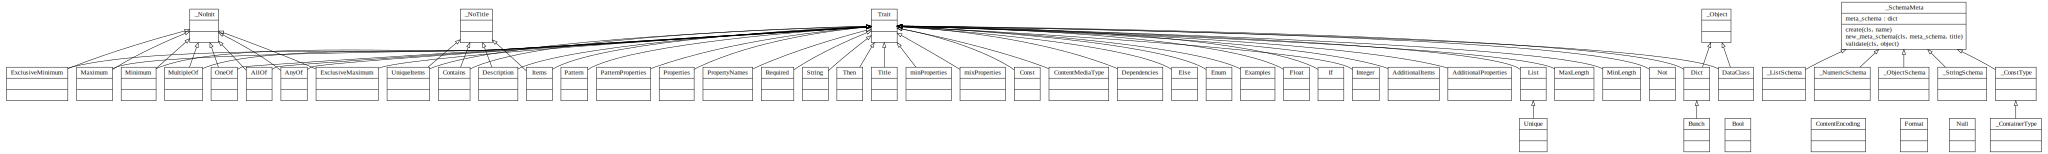

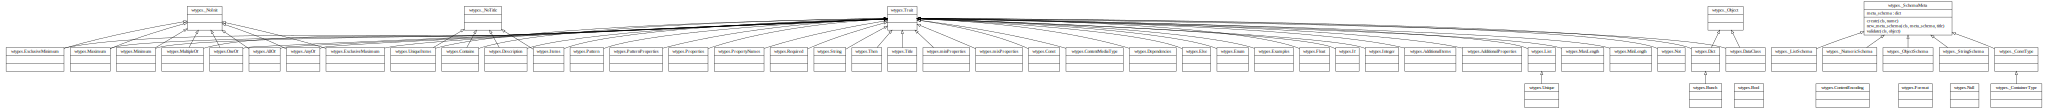

In [14]:
    if __name__ == "__main__":
        if "__file__" in locals():
            if "covtest" in __import__("sys").argv:
                print(__import__("doctest").testmod(optionflags=8))
        else:
            import IPython

            get_ipython().system(
                "jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True wtypes.ipynb"
            )
            with IPython.utils.capture.capture_output():
                get_ipython().system("black wtypes.py")
            get_ipython().system("isort wtypes.py")
            get_ipython().system("ipython -m coverage -- run wtypes.py covtest")
            get_ipython().system("coverage report")
            get_ipython().system("coverage html")
            with IPython.utils.capture.capture_output():
                get_ipython().system("pyreverse wtypes -osvg -pwtypes")
            IPython.display.display(IPython.display.SVG("classes_wtypes.svg"))
            with IPython.utils.capture.capture_output():
                get_ipython().system("pyreverse wtypes -osvg -pwtypes -my -s1")
            IPython.display.display(IPython.display.SVG("classes_wtypes.svg"))